In [26]:
import os
import numpy as np
import torch
import librosa
import pandas as pd
import matplotlib.pyplot as plt

# Your EMOTIONS list
EMOTIONS = ['aggressive', 'relaxed', 'happy', 'sad']

In [38]:
from math import ceil

import torch
import os
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset
import librosa
import numpy as np

import random
import torchvision.transforms as transforms


def add_gaussian_noise(x, mean=0, std=0.1):
    return x + torch.randn_like(x) * std + mean


data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)),
    transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=0.1)),
    transforms.ToTensor()
])


class AudioEmotionDataset(Dataset):
    def __init__(self, data_folder, csv_file, fold_splits=None, fold_indices=None, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.fs = 16000
        self.window = 2048
        self.hop = 512
        self.mel = 512

        if fold_splits is None:
            # Load data and emotion labels from CSV file
            self.data, self.labels = self._load_data_from_csv(csv_file)
        else:
            # Create combined dataset from specified fold indices
            combined_data = []
            combined_labels = []
            for fold_idx in fold_indices:
                if fold_idx < len(fold_splits):
                    fold_data = fold_splits[fold_idx]['data']
                    fold_labels = fold_splits[fold_idx]['labels']
                    combined_data.extend(fold_data)
                    combined_labels.extend(fold_labels)
            self.data = combined_data
            self.labels = combined_labels

    def plot_mel_spectrogram(self, mel_spectrogram, emotion_label):
        print(emotion_label)
        emotion = EMOTIONS[emotion_label]  # Assuming EMOTIONS is a list of emotion labels

        print(emotion)
        plt.figure(figsize=(10, 6))
        plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
        plt.title(f'Mel Spectrogram - Emotion: {emotion}')
        plt.xlabel('Time')
        plt.ylabel('Mel Frequency Bin')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()

    def _load_data_from_csv(self, csv_file):
        data = []
        labels = []
        df = pd.read_csv(csv_file)
        for _, row in df.iterrows():
            file_name = row['file_name']
            emotion = row['emotion']
            data.append(file_name)
            labels.append(emotion)
        return data, labels

    def __len__(self):
        return len(self.data)

    def filter_data_by_emotion(self, emotions):
        filtered_indices = [idx for idx, label in enumerate(self.labels) if label in emotions]
        self.data = [self.data[idx] for idx in filtered_indices]
        self.labels = [self.labels[idx] for idx in filtered_indices]

    def _compute_mel_spectrogram(self, file_path):
        x, sr = librosa.load(file_path, sr=16000, mono=True)

        # Compute mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=x, sr=self.fs, n_fft=self.window, hop_length=self.hop, n_mels=self.mel)
        mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)

        max_length = 256
        if mel_spectrogram.shape[1] > max_length:
            mel_spectrogram = mel_spectrogram[:, :max_length]
        else:
            padding = max_length - mel_spectrogram.shape[1]
            mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, padding)))

        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)

        return mel_spectrogram

    def _apply_data_augmentation(self, mel_spectrogram):
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)
        return mel_spectrogram

    def __getitem__(self, idx):
        file_name = self.data[idx]
        emotion = self.labels[idx]
        instrument_type = 'acoustic-guitar'

        file_path = os.path.join(self.data_folder, instrument_type, emotion, f'{file_name}.wav')

        try:
            mel_spectrogram = self._compute_mel_spectrogram(file_path)

            # Apply data augmentation
            mel_spectrogram = self._apply_data_augmentation(mel_spectrogram)

            # Convert emotion label to numerical index
            emotion_label = EMOTIONS.index(emotion)

            # Visualize the mel spectrogram
            #self.plot_mel_spectrogram(mel_spectrogram, emotion_label)

            return file_name, mel_spectrogram, emotion_label

        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            return torch.zeros((1, 96, 1000)), EMOTIONS.index(emotion)


In [39]:


# Specify your data folder and CSV file
data_folder = 'C:/Users/apurv/Desktop/project/Data'
csv_file = 'C:/Users/apurv/Desktop/project/Data/acoustic-guitar/annotations_acoustic-guitar.csv'

# Create an instance of the dataset
dataset = AudioEmotionDataset(data_folder, csv_file)




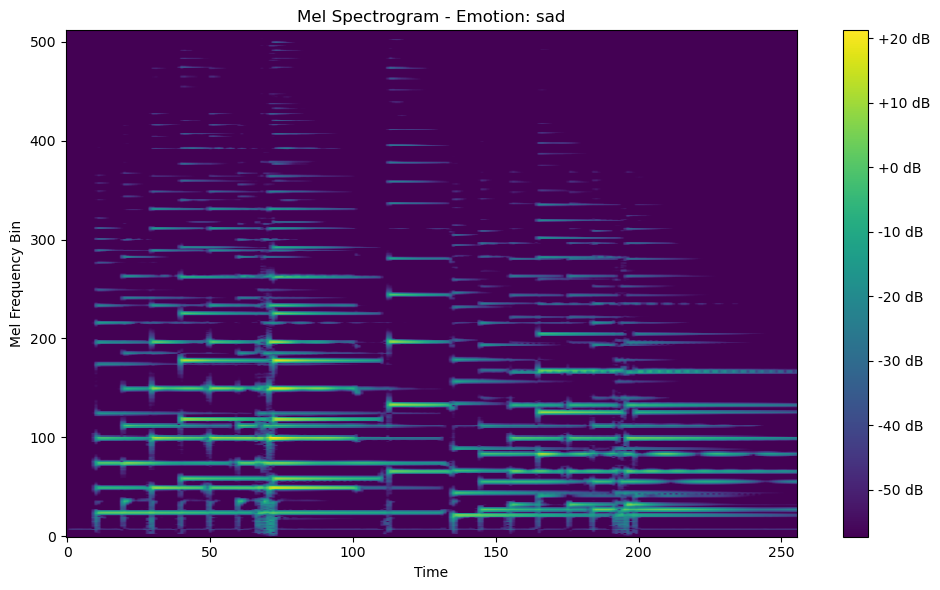

In [48]:

# Select the index of the sample you want to visualize
index_to_visualize = 10

# Load the specific sample and visualize its mel spectrogram
file_name, mel_spectrogram, emotion_label = dataset[index_to_visualize]

# Fetch the emotion name using the emotion_label index
emotion_name = EMOTIONS[emotion_label]

# Visualize the mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram - Emotion: {emotion_name}')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

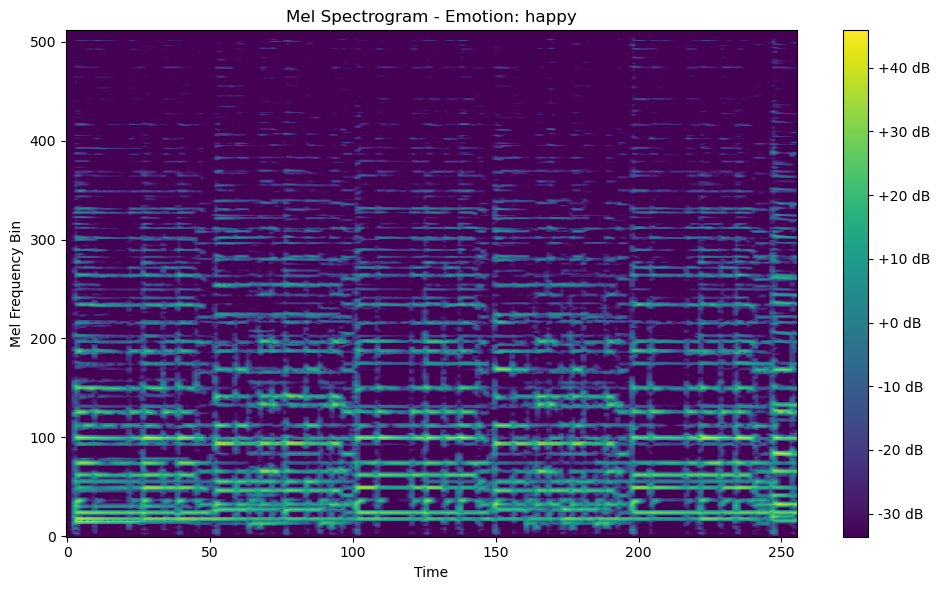

In [49]:
# Select the index of the sample you want to visualize
index_to_visualize = 5

# Load the specific sample and visualize its mel spectrogram
file_name, mel_spectrogram, emotion_label = dataset[index_to_visualize]

# Fetch the emotion name using the emotion_label index
emotion_name = EMOTIONS[emotion_label]

# Visualize the mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram - Emotion: {emotion_name}')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()



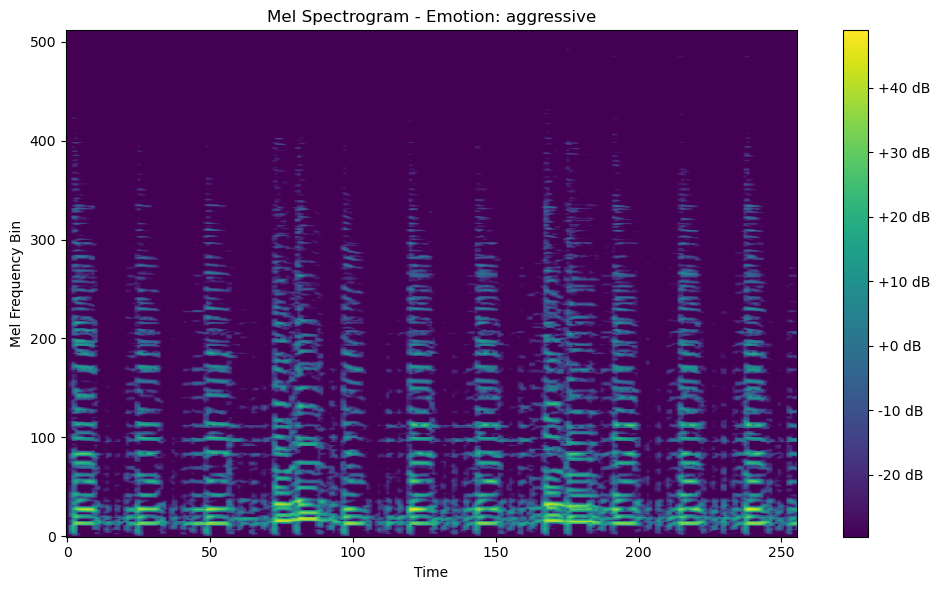

In [50]:
index_to_visualize = 1
# Load the specific sample and visualize its mel spectrogram
file_name, mel_spectrogram, emotion_label = dataset[index_to_visualize]

# Fetch the emotion name using the emotion_label index
emotion_name = EMOTIONS[emotion_label]

# Visualize the mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram - Emotion: {emotion_name}')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

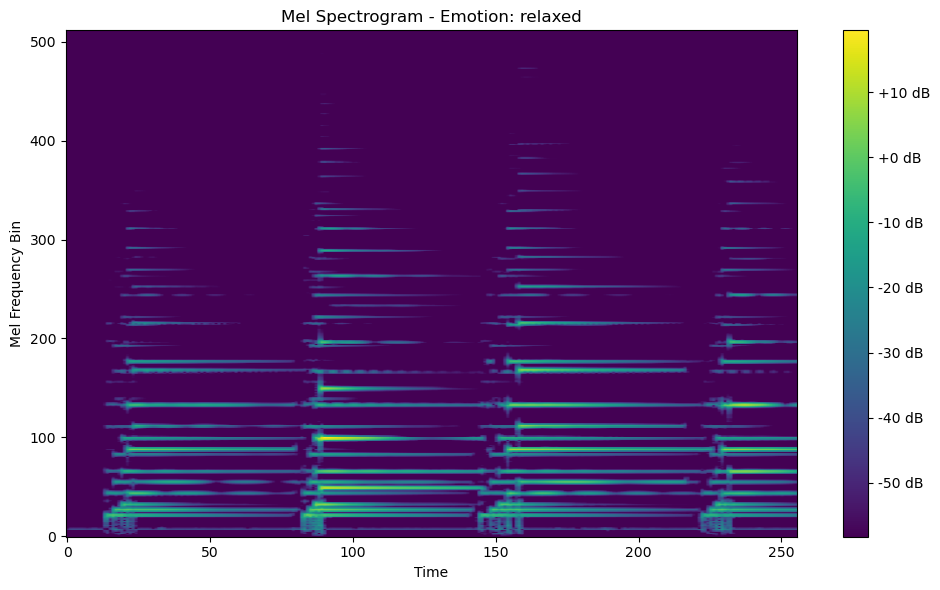

In [52]:
index_to_visualize = 7

# Load the specific sample and visualize its mel spectrogram
file_name, mel_spectrogram, emotion_label = dataset[index_to_visualize]

# Fetch the emotion name using the emotion_label index
emotion_name = EMOTIONS[emotion_label]

# Visualize the mel spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(mel_spectrogram.numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title(f'Mel Spectrogram - Emotion: {emotion_name}')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()